In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jaxley

In [3]:
from jax import config
config.update("jax_enable_x64", False)
device = "cpu"
config.update("jax_platform_name", device)

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".9"

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import jax.numpy as jnp
from jax import jit, value_and_grad, vmap
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

import jaxley as jx
from jaxley.channels import HH
from jaxley.utils.colors import network_cols

In [4]:
from neuron import h

_ = h.load_file("stdlib.hoc")
_ = h.load_file("import3d.hoc")

--No graphics will be displayed.


In [6]:
nseg_per_branch = 4

i_delay = 3.0  # ms
i_dur = 2.0  # ms
dt = 0.025  # ms
t_max = 20.0  # ms


### Define mapping for radiuses

In [7]:
fname = '../morphologies/n144.swc'
_, jx_pathlengths, _, _, _ = jx.utils.swc.swc_to_jaxley(fname, max_branch_len=2000.0)


def get_neuron_radius(fname):
    for sec in h.allsec():
        h.delete_section(sec=sec)
        
    cell_neuron = h.Import3d_SWC_read()
    cell_neuron.input(fname)
    i3d = h.Import3d_GUI(cell_neuron, False)
    i3d.instantiate(None)
    
    for sec in h.allsec():
        sec.nseg = nseg_per_branch

    neuron_radiuses = []
    for i, sec in enumerate(h.allsec()):
        rads_in_sec = []
        for seg in sec:
            neuron_radiuses.append(seg.diam)
    neuron_radiuses = np.asarray(neuron_radiuses) / 2
    return neuron_radiuses


def get_mapping(fname):
    for sec in h.allsec():
        h.delete_section(sec=sec)
        
    cell_neuron = h.Import3d_SWC_read()
    cell_neuron.input(fname)
    i3d = h.Import3d_GUI(cell_neuron, False)
    i3d.instantiate(None)
    
    for sec in h.allsec():
        sec.nseg = nseg_per_branch
    
    neuron_pathlengths = np.asarray([sec.L for sec in h.allsec()])
    
    neuron_to_jaxley_branch_mapping = []
    for i, p in enumerate(jx_pathlengths):
        closest_match = np.argmin(np.abs(neuron_pathlengths - p))
        max_dist = np.min(np.abs(neuron_pathlengths - p))
        assert max_dist < 2e-4, f"{i}, max_dist {max_dist}"
        neuron_to_jaxley_branch_mapping.append(closest_match)
    neuron_to_jaxley_branch_mapping = np.asarray(neuron_to_jaxley_branch_mapping)
    return neuron_to_jaxley_branch_mapping

# jaxley_to_neuron_branch_mapping = []
# for i, p in enumerate(neuron_pathlengths):
#     closest_match = np.argmin(np.abs(jx_pathlengths - p))
#     max_dist = np.min(np.abs(jx_pathlengths - p))
#     assert max_dist < 2e-4, f"{i}, max_dist {max_dist}"
#     jaxley_to_neuron_branch_mapping.append(closest_match)
# jaxley_to_neuron_branch_mapping = np.asarray(jaxley_to_neuron_branch_mapping)

neuron_radiuses = get_neuron_radius(fname)
neuron_to_jaxley_branch_mapping = get_mapping(fname)

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:32: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


### Setup

In [8]:
rec_branches = [0, 34, 54]
i_amp = 0.7  # nA
rec_and_stim_comp = 0.85

### Define Jaxley cell

In [9]:
cell = jx.read_swc(fname, nseg_per_branch, max_branch_len=2000.0)
cell.insert(HH())

current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
cell.branch(0).loc(rec_and_stim_comp).stimulate(current)

for b in rec_branches:
    cell.branch(b).loc(rec_and_stim_comp).record()

for branch_num in range(1, len(cell.comb_parents)):
    for comp in range(nseg_per_branch):
        cell.branch(branch_num).comp(comp).set("radius", neuron_radiuses[nseg_per_branch * neuron_to_jaxley_branch_mapping[branch_num] + comp])
        
cell.set("axial_resistivity", 1_000.0)
cell.set("v", -62.0)
cell.init_states()

cell.branch("all").comp("all").make_trainable("HH_gNa")
cell.branch("all").comp("all").make_trainable("HH_gLeak")
cell.branch("all").comp("all").make_trainable("radius")

parameters = cell.get_parameters()

def simulate_jaxley():
    return jx.integrate(cell, delta_t=dt)

jitted_sim = jit(simulate_jaxley)
voltages_jaxley = jitted_sim()

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 868. Total number of trainable parameters: 868
Number of newly added trainable parameters: 868. Total number of trainable parameters: 1736
Number of newly added trainable parameters: 868. Total number of trainable parameters: 2604


NEURON

In [10]:
for branch_ind, sec in enumerate(h.allsec()):
    if branch_ind > 0:
        for comp, seg in enumerate(sec):
            seg.diam = 2 * neuron_radiuses[nseg_per_branch * branch_ind + comp]

for i, sec in enumerate(h.allsec()):
    if i == 0:
        stim = h.IClamp(sec(rec_and_stim_comp))
        stim.delay = i_delay
        stim.dur = i_dur
        stim.amp = i_amp

counter = 0
voltage_recs = {}
for r, c in zip(neuron_to_jaxley_branch_mapping[rec_branches], [comp for _ in range(len(rec_branches))]):
    for i, sec in enumerate(h.allsec()):
        if i == r:
            v = h.Vector()
            v.record(sec(rec_and_stim_comp)._ref_v)
            voltage_recs[f"v{counter}"] = v
            counter += 1

for sec in h.allsec():
    sec.insert("hh")
    sec.Ra = 1_000.0

    sec.gnabar_hh = 0.120  # S/cm2
    sec.gkbar_hh = 0.036  # S/cm2
    sec.gl_hh = 0.0003  # S/cm2
    sec.ena = 50  # mV
    sec.ek = -77.0  # mV
    sec.el_hh = -54.3  # mV

h.dt = dt
tstop = t_max
v_init = -62.0

def initialize():
    h.finitialize(v_init)
    h.fcurrent()

def integrate():
    while h.t < tstop:
        h.fadvance()

initialize()
integrate()
voltages_neuron = np.asarray([voltage_recs[key] for key in voltage_recs])

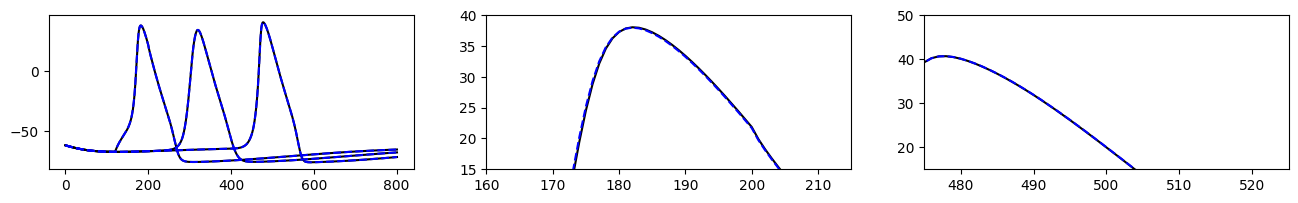

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(16, 2))
_ = ax[0].plot(voltages_neuron.T, c="k")
_ = ax[0].plot(voltages_jaxley.T, c="b", linestyle="--")
_ = ax[1].plot(voltages_neuron.T, c="k") #, marker="o")
_ = ax[1].plot(voltages_jaxley.T, c="b", linestyle="--") #, marker="o")
_ = ax[1].set_xlim([160, 215])
_ = ax[1].set_ylim([15, 40])
_ = ax[2].plot(voltages_neuron.T, c="k") #, marker="o")
_ = ax[2].plot(voltages_jaxley.T, c="b", linestyle="--") #, marker="o")
_ = ax[2].set_xlim([475, 525])
_ = ax[2].set_ylim([15, 50])

In [11]:
time_vec = jnp.arange(0, t_max+2*dt, dt)

jaxley_argmax = np.argmax(voltages_jaxley, axis=1)
neuron_argmax = np.argmax(voltages_neuron, axis=1)

spike_times_jaxley = time_vec[jaxley_argmax]
spike_times_neuron = time_vec[neuron_argmax]

spike_amplitude_jaxley = np.asarray([v[j] for v, j in zip(voltages_jaxley, jaxley_argmax)])
spike_amplitude_neuron = np.asarray([v[j] for v, j in zip(voltages_neuron, neuron_argmax)])

print(f"max difference in spike amplitude: {np.max(np.abs(spike_amplitude_jaxley - spike_amplitude_neuron)):.3f} mV")
print(f"max difference in spike timing:    {np.max(np.abs(spike_times_jaxley - spike_times_neuron)):.3f} ms")

max difference in spike amplitude: 0.071 mV
max difference in spike timing:    0.000 ms


In [12]:
# time_vec = jnp.arange(0, t_max+2*dt, dt)

# with open("../results/01_accuracy/time_vec.pkl", "wb") as handle:
#     pickle.dump(time_vec, handle)

# with open("../results/01_accuracy/voltages_neuron.pkl", "wb") as handle:
#     pickle.dump(voltages_neuron, handle)

# with open("../results/01_accuracy/voltages_jaxley.pkl", "wb") as handle:
#     pickle.dump(voltages_jaxley, handle)

# Simulation

In [13]:
batch_sizes = [1, 10, 100, 1000, 10_000]  # , 1000, 10_000]

In [14]:
computer = "vm"

### Parameters

In [15]:
def simulate_jaxley_vmappable(parameter):
    pstate = cell.branch(0).loc(0.0).data_set("radius", 1e-5 * parameter, None)
    return jx.integrate(cell, delta_t=dt, t_max=t_max, param_state=pstate, voltage_solver="jaxley.stone")

jitted_vmapped_sim = jit(vmap(simulate_jaxley_vmappable, in_axes=[0,]))

In [16]:
# Compile.
for batch_size in batch_sizes:
    _ = jitted_vmapped_sim(jnp.arange(batch_size))

In [17]:
# Run and evaluate.
time_jaxley_gpu = {}
for batch_size in batch_sizes:
    start_time = time.time()
    voltages_batch_100 = jitted_vmapped_sim(jnp.arange(batch_size)).block_until_ready()
    time_jaxley_gpu[batch_size] = time.time() - start_time

In [18]:
# CPU
time_jaxley_gpu

{1: 0.05814695358276367,
 10: 0.5948703289031982,
 100: 3.707876443862915,
 1000: 39.81089663505554,
 10000: 467.8528501987457}

In [19]:
# GPU
time_jaxley_gpu

{1: 0.7883327007293701,
 10: 0.8531155586242676,
 100: 0.9475955963134766,
 1000: 1.3792400360107422,
 10000: 7.584491729736328}

In [19]:
with open(f"../results/03_timing/parameters_n144_jaxley_{device}_{computer}_nseg{nseg_per_branch}.pkl", "wb") as handle:
    pickle.dump(time_jaxley_gpu, handle)

In [21]:
# Evaluate NEURON.
start_time = time.time()
initialize()
integrate()
time_neuron_once = time.time() - start_time

time_neuron = {}
for batch_size in batch_sizes:
    time_neuron[batch_size] = time_neuron_once * batch_size

In [22]:
time_neuron

{1: 0.1521461009979248,
 10: 1.521461009979248,
 100: 15.21461009979248,
 1000: 152.1461009979248,
 10000: 1521.461009979248}

In [23]:
with open(f"../results/03_timing/parameters_n144_neuron_{computer}.pkl", "wb") as handle:
    pickle.dump(time_neuron, handle)

# Gradient

In [20]:
batch_sizes = [1, 10, 100, 1000, 10_000]

### Parameters

In [21]:
def simulate_jaxley_vmappable(parameter):
    pstate = cell.branch(0).loc(0.0).data_set("radius", 1e-5 * parameter, None)
    return jx.integrate(cell, delta_t=dt, t_max=t_max, param_state=pstate, checkpoint_lengths=[10, 9, 9], voltage_solver="jaxley.stone")[0, -1]

vmapped_sim = vmap(simulate_jaxley_vmappable, in_axes=(0,))

def loss(parameters):
    return jnp.mean(vmapped_sim(parameters))

grad_fn = jit(value_and_grad(loss))

In [22]:
# Compile.
for batch_size in batch_sizes:
    _ = grad_fn(jnp.arange(batch_size).astype(float))

2024-07-31 16:24:51.763620: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_loss] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-07-31 16:30:10.125243: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 7m18.361346551s

********************************
[Compiling module jit_loss] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-07-31 16:42:53.486942: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 10m3.592470218s

********************************
[Compiling module jit_loss] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-07-31 16:54:27.490273: E externa

In [23]:
# Run and evaluate.
time_jaxley_gpu = {}
for batch_size in batch_sizes:
    start_time = time.time()
    _ = grad_fn(jnp.arange(batch_size).astype(float))
    time_jaxley_gpu[batch_size] = time.time() - start_time
    print("time_jaxley_gpu", time_jaxley_gpu)

time_jaxley_gpu {1: 0.551513671875}
time_jaxley_gpu {1: 0.551513671875, 10: 4.4556145668029785}
time_jaxley_gpu {1: 0.551513671875, 10: 4.4556145668029785, 100: 39.690566539764404}
time_jaxley_gpu {1: 0.551513671875, 10: 4.4556145668029785, 100: 39.690566539764404, 1000: 453.2918014526367}
time_jaxley_gpu {1: 0.551513671875, 10: 4.4556145668029785, 100: 39.690566539764404, 1000: 453.2918014526367, 10000: 4864.510333061218}


In [24]:
time_jaxley_gpu

{1: 0.551513671875,
 10: 4.4556145668029785,
 100: 39.690566539764404,
 1000: 453.2918014526367,
 10000: 4864.510333061218}

In [19]:
time_jaxley_gpu

{1: 5.068512201309204,
 10: 5.6834681034088135,
 100: 7.231608867645264,
 1000: 13.344197273254395,
 10000: 84.21594095230103}

In [25]:
# time_jaxley_gpu = {
#     1: 9.460421562194824,
#     10: 10.931497573852539,
#     100: 12.73817491531372,
#     1000: 21.95549511909485,
# }

# time_jaxley_gpu_nseg4 = {
#     1: 6.36981201171875,
#     10: 6.706242799758911,
#     100: 7.673536777496338,
#     1000: 12.468173503875732,
#     10000: 80.29185628890991,
# }

In [26]:
# time_jaxley_cpu = {
#     1: 0.8463358879089355,
#     10: 6.132580757141113,
#     100: 70.88474082946777,
#     1000: 999.9903981685638,
# }

In [27]:
with open(f"../results/03_timing/gradient_parameters_n144_jaxley_{device}_{computer}_nseg{nseg_per_branch}.pkl", "wb") as handle:
    pickle.dump(time_jaxley_gpu, handle)